In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Apr 13 22:29:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8              16W / 250W |    968MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [10]:
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
env_id="MountainCar-v0"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env_sb3(env_id, n_envs=1)

print(env.action_space.n)
print(env.observation_space.shape[0])

(500000, 2) (500000,) (500000,) (500000,) (500000,) (500000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]
3
2


In [11]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [17]:

policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
torch.nn.init.kaiming_normal_(policy_network.fc3.weight)



train_dataset = CustomDataset(observations, actions)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)


# Training loop
num_epochs = 1
batch_size = 128

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = len(observations)//100
num_test=10

now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    now_pos=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)


            
            print(total_reward/num_test)
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})
env.close()

    


Epoch [1/1]:   0%|          | 0/3907 [00:00<?, ?it/s, loss=0.907]

Epoch [1/1]:   1%|          | 48/3907 [00:05<08:04,  7.97it/s, loss=0.746] 

[-200.]


Epoch [1/1]:   3%|▎         | 112/3907 [00:10<05:14, 12.08it/s, loss=0.721]

[-200.]


Epoch [1/1]:   3%|▎         | 129/3907 [00:15<08:30,  7.40it/s, loss=0.506]

[-200.]


Epoch [1/1]:   5%|▍         | 190/3907 [00:20<05:53, 10.51it/s, loss=0.453]

[-198.3]


Epoch [1/1]:   5%|▌         | 206/3907 [00:24<08:06,  7.60it/s, loss=0.329]

[-191.7]


Epoch [1/1]:   7%|▋         | 270/3907 [00:29<05:19, 11.40it/s, loss=0.334]

[-169.4]


Epoch [1/1]:   7%|▋         | 286/3907 [00:34<07:45,  7.79it/s, loss=0.26] 

[-139.6]


Epoch [1/1]:   9%|▉         | 344/3907 [00:39<05:48, 10.23it/s, loss=0.235]

[-140.7]


Epoch [1/1]:   9%|▉         | 359/3907 [00:42<06:58,  8.48it/s, loss=0.165]

[-107.3]


Epoch [1/1]:  11%|█         | 424/3907 [00:45<04:08, 14.03it/s, loss=0.284]

[-100.3]


Epoch [1/1]:  11%|█▏        | 440/3907 [00:49<06:26,  8.97it/s, loss=0.236]

[-141.9]


Epoch [1/1]:  13%|█▎        | 502/3907 [00:52<04:01, 14.07it/s, loss=0.245]

[-120.5]


Epoch [1/1]:  13%|█▎        | 518/3907 [00:57<06:03,  9.32it/s, loss=0.232]

[-123.1]


Epoch [1/1]:  15%|█▍        | 578/3907 [01:00<03:57, 14.00it/s, loss=0.218]

[-119.9]


Epoch [1/1]:  15%|█▌        | 593/3907 [01:03<05:21, 10.32it/s, loss=0.321]

[-152.8]


Epoch [1/1]:  17%|█▋        | 658/3907 [01:06<03:27, 15.64it/s, loss=0.33] 

[-121.]


Epoch [1/1]:  17%|█▋        | 673/3907 [01:09<04:49, 11.16it/s, loss=0.163]

[-130.7]


Epoch [1/1]:  19%|█▉        | 736/3907 [01:14<04:03, 13.01it/s, loss=0.27] 

[-159.4]


Epoch [1/1]:  19%|█▉        | 751/3907 [01:18<06:08,  8.58it/s, loss=0.22] 

[-133.1]


Epoch [1/1]:  21%|██        | 813/3907 [01:22<03:50, 13.40it/s, loss=0.158]

[-116.]


Epoch [1/1]:  21%|██        | 828/3907 [01:25<05:03, 10.14it/s, loss=0.216]

[-126.1]


Epoch [1/1]:  23%|██▎       | 892/3907 [01:28<03:17, 15.23it/s, loss=0.216]

[-114.8]


Epoch [1/1]:  23%|██▎       | 907/3907 [01:31<04:35, 10.90it/s, loss=0.24] 

[-126.2]


Epoch [1/1]:  25%|██▍       | 971/3907 [01:34<03:00, 16.24it/s, loss=0.207]

[-122.8]


Epoch [1/1]:  25%|██▌       | 987/3907 [01:37<04:09, 11.68it/s, loss=0.26] 

[-116.7]


Epoch [1/1]:  27%|██▋       | 1044/3907 [01:40<02:56, 16.26it/s, loss=0.165]

[-106.8]


Epoch [1/1]:  28%|██▊       | 1090/3907 [01:43<02:45, 17.00it/s, loss=0.175]

[-132.7]


Epoch [1/1]:  28%|██▊       | 1107/3907 [01:46<03:58, 11.74it/s, loss=0.132]

[-135.1]


Epoch [1/1]:  30%|██▉       | 1164/3907 [01:49<02:55, 15.60it/s, loss=0.193]

[-109.1]


Epoch [1/1]:  31%|███       | 1206/3907 [01:53<02:50, 15.86it/s, loss=0.246]

[-132.7]


Epoch [1/1]:  31%|███▏      | 1222/3907 [01:56<04:02, 11.08it/s, loss=0.23] 

[-106.7]


Epoch [1/1]:  33%|███▎      | 1283/3907 [01:59<02:43, 16.05it/s, loss=0.193]

[-113.8]


Epoch [1/1]:  33%|███▎      | 1299/3907 [02:02<03:48, 11.41it/s, loss=0.276] 

[-113.1]


Epoch [1/1]:  35%|███▍      | 1359/3907 [02:05<02:42, 15.63it/s, loss=0.175]

[-132.7]


Epoch [1/1]:  35%|███▌      | 1374/3907 [02:08<03:33, 11.87it/s, loss=0.185]

[-110.8]


Epoch [1/1]:  37%|███▋      | 1437/3907 [02:13<03:01, 13.63it/s, loss=0.174]

[-128.]


Epoch [1/1]:  38%|███▊      | 1483/3907 [02:17<02:54, 13.92it/s, loss=0.272] 

[-120.7]


Epoch [1/1]:  38%|███▊      | 1500/3907 [02:20<03:53, 10.31it/s, loss=0.16] 

[-132.7]


Epoch [1/1]:  40%|███▉      | 1557/3907 [02:24<02:46, 14.08it/s, loss=0.224]

[-103.6]


Epoch [1/1]:  40%|████      | 1573/3907 [02:27<03:43, 10.43it/s, loss=0.188]

[-115.1]


Epoch [1/1]:  42%|████▏     | 1636/3907 [02:29<02:15, 16.76it/s, loss=0.129]

[-120.1]


Epoch [1/1]:  42%|████▏     | 1652/3907 [02:32<03:15, 11.52it/s, loss=0.153]

[-123.2]


Epoch [1/1]:  44%|████▍     | 1711/3907 [02:36<02:20, 15.66it/s, loss=0.196] 

[-124.1]


Epoch [1/1]:  44%|████▍     | 1726/3907 [02:39<03:13, 11.25it/s, loss=0.354] 

[-113.9]


Epoch [1/1]:  46%|████▌     | 1788/3907 [02:41<02:05, 16.93it/s, loss=0.21] 

[-114.7]


Epoch [1/1]:  47%|████▋     | 1834/3907 [02:44<01:56, 17.79it/s, loss=0.171] 

[-101.2]


Epoch [1/1]:  47%|████▋     | 1851/3907 [02:47<02:49, 12.16it/s, loss=0.201]

[-106.2]


Epoch [1/1]:  49%|████▉     | 1907/3907 [02:50<02:00, 16.62it/s, loss=0.237]

[-106.6]


Epoch [1/1]:  49%|████▉     | 1923/3907 [02:53<02:37, 12.63it/s, loss=0.206] 

[-119.6]


Epoch [1/1]:  51%|█████     | 1984/3907 [02:57<02:08, 15.02it/s, loss=0.101]

[-131.6]


Epoch [1/1]:  52%|█████▏    | 2031/3907 [03:01<02:11, 14.27it/s, loss=0.183] 

[-115.7]


Epoch [1/1]:  52%|█████▏    | 2048/3907 [03:04<02:53, 10.71it/s, loss=0.157] 

[-112.9]


Epoch [1/1]:  54%|█████▍    | 2101/3907 [03:08<02:03, 14.63it/s, loss=0.122]

[-116.4]


Epoch [1/1]:  55%|█████▍    | 2144/3907 [03:10<01:46, 16.50it/s, loss=0.162]

[-111.1]


Epoch [1/1]:  55%|█████▌    | 2160/3907 [03:13<02:35, 11.27it/s, loss=0.249]

[-111.8]


Epoch [1/1]:  57%|█████▋    | 2221/3907 [03:17<01:43, 16.28it/s, loss=0.246]

[-121.3]


Epoch [1/1]:  57%|█████▋    | 2237/3907 [03:22<03:07,  8.92it/s, loss=0.225]

[-122.7]


Epoch [1/1]:  59%|█████▊    | 2295/3907 [03:25<01:58, 13.58it/s, loss=0.161] 

[-111.1]


Epoch [1/1]:  60%|█████▉    | 2340/3907 [03:30<02:12, 11.83it/s, loss=0.208]

[-130.2]


Epoch [1/1]:  60%|██████    | 2356/3907 [03:33<02:35, 10.00it/s, loss=0.213]

[-104.2]


Epoch [1/1]:  62%|██████▏   | 2415/3907 [03:36<01:38, 15.13it/s, loss=0.146]

[-103.1]


Epoch [1/1]:  63%|██████▎   | 2460/3907 [03:38<01:25, 16.94it/s, loss=0.227]

[-103.1]


Epoch [1/1]:  63%|██████▎   | 2477/3907 [03:41<01:52, 12.70it/s, loss=0.219]

[-118.]


Epoch [1/1]:  65%|██████▍   | 2524/3907 [03:44<01:27, 15.84it/s, loss=0.132]

[-116.]


Epoch [1/1]:  66%|██████▌   | 2572/3907 [03:47<01:16, 17.53it/s, loss=0.165] 

[-105.5]


Epoch [1/1]:  67%|██████▋   | 2615/3907 [03:49<01:09, 18.71it/s, loss=0.169] 

[-113.]


Epoch [1/1]:  67%|██████▋   | 2631/3907 [03:52<01:44, 12.22it/s, loss=0.103]

[-122.2]


Epoch [1/1]:  69%|██████▉   | 2690/3907 [03:55<01:10, 17.36it/s, loss=0.217] 

[-103.]


Epoch [1/1]:  69%|██████▉   | 2706/3907 [03:58<01:42, 11.72it/s, loss=0.185] 

[-116.2]


Epoch [1/1]:  71%|███████   | 2768/3907 [04:02<01:09, 16.46it/s, loss=0.244]

[-127.2]


Epoch [1/1]:  71%|███████▏  | 2784/3907 [04:04<01:33, 12.05it/s, loss=0.21]  

[-130.3]


Epoch [1/1]:  73%|███████▎  | 2841/3907 [04:08<01:06, 15.91it/s, loss=0.175] 

[-104.8]


Epoch [1/1]:  74%|███████▍  | 2889/3907 [04:10<00:55, 18.29it/s, loss=0.173] 

[-106.1]


Epoch [1/1]:  74%|███████▍  | 2906/3907 [04:13<01:20, 12.41it/s, loss=0.128] 

[-116.6]


Epoch [1/1]:  76%|███████▌  | 2965/3907 [04:16<00:53, 17.70it/s, loss=0.222]

[-109.1]


Epoch [1/1]:  76%|███████▋  | 2982/3907 [04:19<01:13, 12.61it/s, loss=0.155] 

[-103.3]


Epoch [1/1]:  78%|███████▊  | 3043/3907 [04:22<00:48, 17.77it/s, loss=0.143] 

[-111.3]


Epoch [1/1]:  78%|███████▊  | 3060/3907 [04:25<01:08, 12.32it/s, loss=0.108] 

[-117.9]


Epoch [1/1]:  80%|███████▉  | 3116/3907 [04:27<00:45, 17.52it/s, loss=0.148] 

[-100.7]


Epoch [1/1]:  80%|████████  | 3131/3907 [04:30<01:03, 12.23it/s, loss=0.126] 

[-107.1]


Epoch [1/1]:  82%|████████▏ | 3196/3907 [04:33<00:37, 18.90it/s, loss=0.174] 

[-114.6]


Epoch [1/1]:  82%|████████▏ | 3211/3907 [04:35<00:50, 13.73it/s, loss=0.156] 

[-100.8]


Epoch [1/1]:  84%|████████▍ | 3277/3907 [04:38<00:33, 19.06it/s, loss=0.157] 

[-115.4]


Epoch [1/1]:  84%|████████▍ | 3293/3907 [04:41<00:47, 12.99it/s, loss=0.174]

[-106.1]


Epoch [1/1]:  86%|████████▌ | 3349/3907 [04:44<00:33, 16.48it/s, loss=0.142] 

[-102.5]


Epoch [1/1]:  87%|████████▋ | 3396/3907 [04:47<00:28, 18.25it/s, loss=0.202] 

[-104.9]


Epoch [1/1]:  87%|████████▋ | 3413/3907 [04:50<00:39, 12.41it/s, loss=0.202]

[-124.1]


Epoch [1/1]:  89%|████████▉ | 3472/3907 [04:53<00:25, 17.30it/s, loss=0.145] 

[-113.8]


Epoch [1/1]:  89%|████████▉ | 3488/3907 [04:56<00:34, 12.18it/s, loss=0.122] 

[-110.]


Epoch [1/1]:  91%|█████████ | 3551/3907 [04:58<00:19, 18.42it/s, loss=0.236]

[-108.7]


Epoch [1/1]:  91%|█████████▏| 3568/3907 [05:01<00:26, 12.86it/s, loss=0.15]  

[-104.]


Epoch [1/1]:  93%|█████████▎| 3625/3907 [05:04<00:15, 17.70it/s, loss=0.176] 

[-97.8]


Epoch [1/1]:  93%|█████████▎| 3640/3907 [05:07<00:21, 12.31it/s, loss=0.206] 

[-104.9]


Epoch [1/1]:  95%|█████████▍| 3706/3907 [05:10<00:10, 18.52it/s, loss=0.189] 

[-101.1]


Epoch [1/1]:  95%|█████████▌| 3722/3907 [05:12<00:14, 12.91it/s, loss=0.174] 

[-109.6]


Epoch [1/1]:  97%|█████████▋| 3784/3907 [05:15<00:06, 18.69it/s, loss=0.107] 

[-122.8]


Epoch [1/1]:  97%|█████████▋| 3800/3907 [05:18<00:08, 13.10it/s, loss=0.187] 

[-108.4]


Epoch [1/1]:  99%|█████████▉| 3864/3907 [05:21<00:02, 18.23it/s, loss=0.16]  

[-108.8]


Epoch [1/1]:  99%|█████████▉| 3880/3907 [05:25<00:02, 10.16it/s, loss=0.131] 

[-114.5]


Epoch [1/1]: 100%|██████████| 3907/3907 [05:28<00:00, 11.88it/s, loss=0.293]

[-114.7]


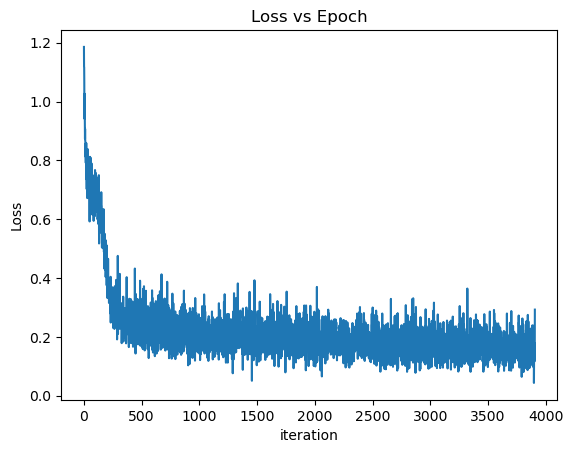

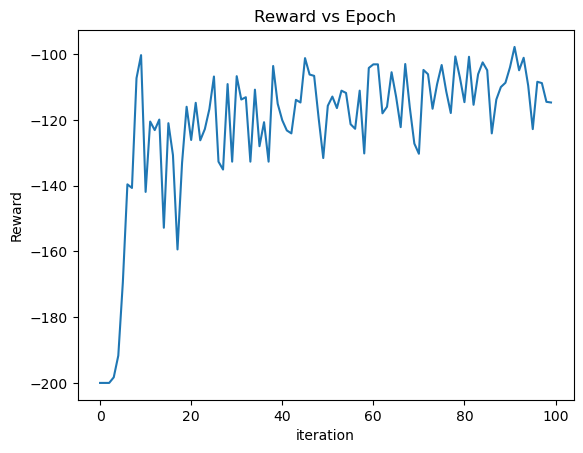

In [19]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("iteration")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.savefig("./reward.png")
plt.show()


